# Working with Meshes

This tutorial shows how to expedite working with kaolin operations using the `SurfaceMesh` container class. We will cover import/export, batching strategies, managing mesh data, rendering and visualization. 

Note that material support of `SurfaceMesh` is currently limited and is on the roadmap.

In [1]:
pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.

In [2]:
import copy
import logging
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import torch

import kaolin as kal
from kaolin.rep import SurfaceMesh

from tutorial_common import COMMON_DATA_DIR

def sample_mesh_path(fname):
    return os.path.join(COMMON_DATA_DIR, 'meshes', fname)

def print_tensor(t, **kwargs):
    print(kal.utils.testing.tensor_info(t, **kwargs))

## Understanding the SurfaceMesh Container

`SurfaceMesh` can store information about a single mesh and a batch of meshes, following three batching
strategies:
   * `NONE` - a single mesh, not batched
   * `FIXED` - a batch of meshes with fixed topology (faces are fixed)
   * `LIST` - a list of variable topology meshes

Automatically converting between these batching strategies allows quickly connecting to various Kaolin operations. 

In [3]:
# To get a sense for what the mesh can contain for different batching strategies, run:

print(SurfaceMesh.attribute_info_string(SurfaceMesh.Batching.FIXED))
print('\nKey: B - batch size, F - number of faces, FSz - face size, V - number of vertices,'
      '\n     VN - number of normals, U - number of UVs')

Expected SurfaceMesh contents for batching strategy FIXED
            vertices: (torch.FloatTensor) of shape ['B', 'V', 3]
               faces: (torch.IntTensor)   of shape ['F', 'FSz']
       face_vertices: (torch.FloatTensor) of shape ['B', 'F', 'FSz', 3]
             normals: (torch.FloatTensor) of shape ['B', 'VN', 3]
    face_normals_idx: (torch.IntTensor)   of shape ['B', 'F', 'FSz']
        face_normals: (torch.FloatTensor) of shape ['B', 'F', 'FSz', 3]
                 uvs: (torch.FloatTensor) of shape ['B', 'U', 2]
        face_uvs_idx: (torch.IntTensor)   of shape ['B', 'F', 'FSz']
            face_uvs: (torch.FloatTensor) of shape ['B', 'F', 'FSz', 2]
      vertex_normals: (torch.FloatTensor) of shape ['B', 'V', 3]
     vertex_tangents: (torch.FloatTensor) of shape ['B', 'V', 3]
       vertex_colors: (torch.FloatTensor) of shape ['B', 'V', None]
     vertex_features: (torch.FloatTensor) of shape ['B', 'V', None]
       face_tangents: (torch.FloatTensor) of shape ['B', 'F', 

## Constructor and Auto-computable Attributes

A `SurfaceMesh` can be constructed from torch tensors with names, types and sizes as described above. Only `faces` and `vertices` are required, both of which are allowed to contain zero elements, and **many attributes can be computed automatically**. 

Important settings passed to the constructor:
* `unset_attributes_return_none` (default: `True`) - set this to `False` to raise an error when accessing mesh attributes that are missing
* `allow_auto_compute` (default: `True`) - set this to `False` to disable computation of attributes such as `face_uvs` and `vertex_normals`
* `strict_checks` (default: `True`) - set this to `False` to allow setting attributes to unexpected shapes

You can also set `mesh.unset_attributes_return_none` or `mesh.allow_auto_compute` later to change mesh behavior.

In [4]:
# Let's construct a simple unbatched mesh
V, F, Fsz = 10, 5, 3
mesh = kal.rep.SurfaceMesh(vertices=torch.rand((V, 3)).float(),
                           faces=torch.randint(0, V, (F, Fsz)).long(),
                           allow_auto_compute=False)  # disable auto-compute for now
print_tensor(mesh.vertices, name='vertices')
print_tensor(mesh.faces, name='faces')
print_tensor(mesh.face_vertices, name='face_vertices')

# Now let's enable auto-compute
mesh.allow_auto_compute=True
print_tensor(mesh.face_vertices, name='face_vertices (auto-computed)')                                

vertices: [10, 3] (torch.float32)[cpu]  
faces: [5, 3] (torch.int64)[cpu]  
face_vertices: None
face_vertices (auto-computed): [5, 3, 3] (torch.float32)[cpu]  


Batched meshes can also be instantiated by passing batched inputs to the constructor, for example:

In [5]:
# FIXED: inputs are batched tensors with fixed faces across batches
B, VN = 3, 20
mesh_fixed = kal.rep.SurfaceMesh(vertices=torch.rand((B, V, 3)).float(),
                                 faces=torch.randint(0, V, (F, Fsz)).long(),
                                 normals=torch.rand((B, VN, 3)).float(),
                                 face_normals_idx=torch.randint(0, VN, (B, F, Fsz)))
print(f'Instantiated mesh with batching {mesh_fixed.batching} and length {len(mesh_fixed)}')

# LIST: all inputs are lists of equal length
V2, F2 = 12, 20
mesh_list = kal.rep.SurfaceMesh(
    vertices=[torch.rand((V, 3)).float(), torch.rand((V2, 3)).float()],
    faces=[torch.randint(0, V, (F, Fsz)).long(), torch.randint(0, V2, (F2, Fsz)).long()])
print(f'Instantiated mesh with batching {mesh_list.batching} and length {len(mesh_list)}')

Instantiated mesh with batching FIXED and length 3
Instantiated mesh with batching LIST and length 2


## Inspecting SurfaceMesh Objects

Working with many batched mesh attributes can be confusing, and details really matter. `SurfaceMesh` provides multiple ways to inspect its contents. These print statements also make it clear, which attributes can be auto-computed and how.

In [6]:
# Get batching strategy and batch size (length)
print(f'\nMesh with batching {mesh.batching} and length {len(mesh)}')

# Get currently set attributes
print(f'\nAttributes {mesh.get_attributes(only_tensors=True)}')

# Check if an attribute is set without causing the mesh to auto-compute it
print(f'\nAre face_normals set? {mesh.has_attribute("face_normals")}')

# Check if the attribute likely can be auto-computed without actually trying to
print(f'\nAre face_normals auto-computable? {mesh.probably_can_compute_attribute("face_normals")}')

# Let's access face_normals and cause them to be computed
mesh.face_normals
print(f'\nAttributes (after accessing face_normals) {mesh.get_attributes(only_tensors=True)}')

# Check that face_normals are now set
print(f'\nFace normals{mesh.describe_attribute("face_normals")}\n')

# Check if mesh tensor sizes follow expected conventions
print(f'\nDoes the mesh have expected shapes? {mesh.check_sanity()}')

# Print mesh contents (and computable attributes)
print(mesh)

# We can also convert mesh to string with more details and tensor stats
# print(f'\nDetailed string of {mesh.to_string(detailed=True, print_stats=True)}')


Mesh with batching NONE and length 1

Attributes ['vertices', 'faces', 'face_vertices']

Are face_normals set? False

Are face_normals auto-computable? True

Attributes (after accessing face_normals) ['vertices', 'faces', 'face_vertices', 'face_normals']

Face normals        face_normals: [5, 3, 3] (torch.float32)[cpu]  


Does the mesh have expected shapes? True
SurfaceMesh object with batching strategy NONE
            vertices: [10, 3] (torch.float32)[cpu]  
               faces: [5, 3] (torch.int64)[cpu]  
       face_vertices: [5, 3, 3] (torch.float32)[cpu]  
        face_normals: [5, 3, 3] (torch.float32)[cpu]  
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features:

## Explicit API

In addition to default `SurfaceMesh` API that allows compute on access and automatic caching, this class also supports alternative more verbose API that makes these actions explicit.

In [7]:
# Let's delete attributes we just computed
mesh.face_vertices = None
mesh.face_normals = None

# Check attributes were removed
print(f'\nMesh attributes after deletion: {mesh.get_attributes(only_tensors=True)}')

# Get attribute without any auto-compute magic
print(f'\nGet face_normals without computing: {mesh.get_attribute("face_normals")}')

# Compute attribute, but don't cache
face_normals = mesh.get_or_compute_attribute('face_normals', should_cache=False)
print(f'\nComputed face_normals shape is {face_normals.shape}')

# Verify attributes were not cached
print('\nDid mesh cache computed face_normals (and face_vertices required to compute them)?')
print(f'{mesh.has_attribute("face_normals")}, {mesh.has_attribute("face_vertices")}')

# Compute and cache
face_normals = mesh.get_or_compute_attribute('face_normals', should_cache=True)

print('\nDid mesh cache computed face_normals (and face_vertices required to compute them)?')
print(f'{mesh.has_attribute("face_normals")}, {mesh.has_attribute("face_vertices")}')

Deleting face_vertices
Deleting face_normals

Mesh attributes after deletion: ['vertices', 'faces']

Get face_normals without computing: None

Computed face_normals shape is torch.Size([5, 3, 3])

Did mesh cache computed face_normals (and face_vertices required to compute them)?
False, False

Did mesh cache computed face_normals (and face_vertices required to compute them)?
True, True


## Importing Data

Since version 0.14.0, kaolin `obj` and `usd` importers return a `SurfaceMesh`, which is nearly backward-compatible with the previous `named_tuple` return type, while providing mutability and convenient data management. Version 0.15.0 added `gltf` importer, as well as support for `vertex_tangents` in the mesh. Version 0.16.0 introduced subtle changes that make data imported from all three formats consistent, and also added `kaolin.io.import_mesh` that calls appropriate method based on filename extension.

**Porting from v0.15.0:** If porting from kaolin 0.15.0, importers now try to read materials into the same class `kaolin.render.materials.PBRMaterial` consistently. For `obj`, set `raw_materials=False` to enable this option. The `SurfaceMesh` class can also now forward methods like `cuda()` to the contained materials. Additionally, subtle changes were made to `USD` importer, and `obj` importer now uses different convention for `Y` of the `UV` coordinates (set `uvs[...,1] = 1-uvs[...,1]` to restore old behavior.

**Porting from earlier versions:** If porting from kaolin<=0.13.0, `obj` importer now correctly uses `face_normals_idx` (previously `face_normals`) to refer to the face-vertex indices into normals and `normals` (previously `vertex_normals`) to refer to the normals array that may or may not have the same number of elements as vertices. In addition, `materials` are now imported in name-sorted order and `material_order` has been replaced with `material_assignments` tensor of shape `(num_faces,)`, with integer value indicating the material index assigned to the corresponding face.

In [8]:
import_args = {'with_materials' : True, 'with_normals' : True}

# Let's import a single mesh from OBJ
mesh_obj = kal.io.obj.import_mesh(sample_mesh_path('ico_flat.obj'), raw_materials=False, **import_args)

# Let's import the same mesh from its USD version
mesh_usd = kal.io.usd.import_mesh(sample_mesh_path('ico_flat.usda'), **import_args)

# Let's inspect contents of both meshes (notice consistent naming of attributes)
print(f'\nMesh imported from obj: {mesh_obj}')
print(f'\nMesh imported from usd: {mesh_usd}')

# Note: if you prefer to work with raw values, SurfaceMesh is convertible to dict
mesh_dict = mesh_usd.as_dict()
print(mesh_dict.keys())


Mesh imported from obj: SurfaceMesh object with batching strategy NONE
            vertices: [42, 3] (torch.float32)[cpu]  
               faces: [80, 3] (torch.int64)[cpu]  
             normals: [80, 3] (torch.float32)[cpu]  
    face_normals_idx: [80, 3] (torch.int64)[cpu]  
                 uvs: [63, 2] (torch.float32)[cpu]  
        face_uvs_idx: [80, 3] (torch.int64)[cpu]  
material_assignments: [80] (torch.int16)[cpu]  
           materials: list of length 1
       face_vertices: if possible, computed on access from: (faces, vertices)
        face_normals: if possible, computed on access from: (normals, face_normals_idx) or (vertex_normals, faces) or (vertices, faces)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed 

Although geometrically these objects are the same, you will notice that USD stroes UVs and normals differently from OBJ, resulting in different imported arrays. Despite these differences, actual UVs and normals auto-computed and assigned to faces are actually the same.

In [9]:
print(f'\nAre face_uvs same? {torch.allclose(mesh_obj.face_uvs, mesh_usd.face_uvs, atol=1e-4)}')
print(f'\nAre face_normals same? {torch.allclose(mesh_obj.face_normals, mesh_usd.face_normals, atol=1e-4)}')


Are face_uvs same? True

Are face_normals same? True


## Visualizing

Kaolin provides an easy to render function, with PBR material support, which outputs multiple passes. For example, let's load and render this multi-material USD file.

(Note that material standards vary widely and for USD we only support `USDPreviewSurface` spec at this time, as well as partial PBR support for `gltf` and `obj`).

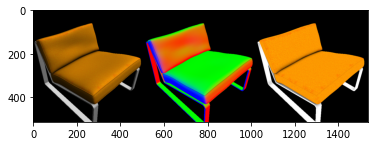

In [10]:
if torch.cuda.is_available():
    # Import and triangulate to enable rasterization
    pretty_mesh = kal.io.import_mesh(sample_mesh_path('armchair.usdc'), triangulate=True).cuda()
    
    # Normalize so it is easy to set up default camera
    pretty_mesh.vertices = kal.ops.pointcloud.center_points(pretty_mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)
    
    # Default rendering settings
    camera = kal.render.easy_render.default_camera(512).cuda()
    lighting = kal.render.easy_render.default_lighting().cuda()

def render(in_cam):
    render_res = kal.render.easy_render.render_mesh(in_cam, pretty_mesh, lighting=lighting)
    # render pass
    img = render_res[kal.render.easy_render.RenderPass.render].squeeze(0).clamp(0, 1)
    # normals pass
    normals = render_res[kal.render.easy_render.RenderPass.normals].squeeze(0).clamp(0, 1)
    # albedo pass
    albedo = render_res[kal.render.easy_render.RenderPass.albedo].squeeze(0).clamp(0, 1)
    return (torch.cat([img, normals, albedo], dim=1) * 255.).to(torch.uint8)

# Show simple render
if torch.cuda.is_available():
    plt.figure()
    plt.imshow(render(camera).cpu().numpy())

## Visualizing Interactively

Given any render function that takes a Kaolin `Camera`, we can also interactively change view right inside the `Jupyter` notebook.

Run this cell, and click and drag inside the rendered viewport (note: first interaction can be slow).

In [11]:
def fast_render(in_cam, factor=8):
    lowres_cam = copy.deepcopy(in_cam)
    lowres_cam.width = in_cam.width // factor
    lowres_cam.height = in_cam.height // factor
    return render(lowres_cam)

visualizer = kal.visualize.IpyTurntableVisualizer(
    512, 512 * 3, copy.deepcopy(camera), render, fast_render=fast_render,
    max_fps=24, world_up_axis=1)
visualizer.show()

Canvas(height=512, width=1536)

Output()

## Working with Batches

`SurfaceMesh` objects can be converted between batching strategies, as long as it is possible (for example list of meshes of variable topology cannot be converted to `Batching.FIXED`). 

In [12]:
# Convert unbatched mesh to most commonly used FIXED batching
mesh_obj.to_batched()  # Shortcut for mesh_usd.set_batching(SurfaceMesh.Batching.FIXED)
print(mesh_obj)

# Convert mesh to list batching
mesh_usd.set_batching(SurfaceMesh.Batching.LIST)
print(f'\n{mesh_usd}')

SurfaceMesh object with batching strategy FIXED
            vertices: [1, 42, 3] (torch.float32)[cpu]  
               faces: [80, 3] (torch.int64)[cpu]  
             normals: [1, 80, 3] (torch.float32)[cpu]  
    face_normals_idx: [1, 80, 3] (torch.int64)[cpu]  
        face_normals: [1, 80, 3, 3] (torch.float32)[cpu]  
                 uvs: [1, 63, 2] (torch.float32)[cpu]  
        face_uvs_idx: [1, 80, 3] (torch.int64)[cpu]  
            face_uvs: [1, 80, 3, 2] (torch.float32)[cpu]  
material_assignments: [1, 80] (torch.int16)[cpu]  
           materials: [
                      0: list of length 1
                      ]
       face_vertices: if possible, computed on access from: (faces, vertices)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_feat

We can also concatenate meshes of any batching strategy, with the output using `FIXED` (if `fixed_toplogy`) or `LIST` batching. Errors will be raised if concatentation is not possible for `vertices` or `faces`, and other attributes will be handled if possible. 

In [13]:
mesh = SurfaceMesh.cat([mesh_obj, mesh_usd], fixed_topology=True)

# Notice that the concatenated mesh:
# 1. does not have uvs, as those could not be stacked, but face_uvs were computed and stacked instead.
# 2. does not have normals, as only first mesh had them, but face_normals were computed and stacked. 
print(mesh)

SurfaceMesh object with batching strategy FIXED
            vertices: [2, 42, 3] (torch.float32)[cpu]  
               faces: [80, 3] (torch.int64)[cpu]  
        face_normals: [2, 80, 3, 3] (torch.float32)[cpu]  
            face_uvs: [2, 80, 3, 2] (torch.float32)[cpu]  
material_assignments: [2, 80] (torch.int16)[cpu]  
           materials: [
                      0: list of length 1
                      1: list of length 1
                      ]
       face_vertices: if possible, computed on access from: (faces, vertices)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features: if possible, computed on access from: (faces, face_features)
       face_tangents: if possible, computed on access from: (faces, vertex_tangents)
         face_colors: if p

With `fixed_topology=False`, it is also possible to concatenate meshes of variable topology into a list representation. For example:

In [14]:
tmp = SurfaceMesh.cat([mesh, kal.io.usd.import_mesh(sample_mesh_path('pizza.usda'), **import_args)],
                      fixed_topology=False)
print(tmp)
tmp.vertex_normals
print(f'\nNote that auto-compute is still supported, e.g. after access:')
print(f'{tmp.describe_attribute("vertex_normals")}')

del tmp  # not needed later

SurfaceMesh object with batching strategy LIST
            vertices: [
                      0: [42, 3] (torch.float32)[cpu]  
                      1: [42, 3] (torch.float32)[cpu]  
                      2: [482, 3] (torch.float32)[cpu]  
                      ]
               faces: [
                      0: [80, 3] (torch.int64)[cpu]  
                      1: [80, 3] (torch.int64)[cpu]  
                      2: [960, 3] (torch.int64)[cpu]  
                      ]
        face_normals: [
                      0: [80, 3, 3] (torch.float32)[cpu]  
                      1: [80, 3, 3] (torch.float32)[cpu]  
                      2: [960, 3, 3] (torch.float32)[cpu]  
                      ]
            face_uvs: [
                      0: [80, 3, 2] (torch.float32)[cpu]  
                      1: [80, 3, 2] (torch.float32)[cpu]  
                      2: [960, 3, 2] (torch.float32)[cpu]  
                      ]
material_assignments: [
                      0: [80] (torch.int16)[cpu] 

## Convenience Methods and Mutability

Now let's see a few useful capabilities of `SurfaceMesh`. 

In [15]:
# Recall that mesh contains two fixed topology meshes

# Let's move it to cuda (you can also specify particular attributes to move)
mesh = mesh.cuda()

# Let's say we actually don't need vertex_normals on the GPU
mesh = mesh.cpu(attributes=['vertex_normals'])
print(mesh)

# We can also directly set mesh attributes, for example:
print(mesh.describe_attribute('vertices', print_stats=True))
mesh.vertices = kal.ops.pointcloud.center_points(mesh.vertices, normalize=True)
print(mesh.describe_attribute('vertices', print_stats=True))

# Mesh also supports copy and deepcopy
mesh_copy = copy.copy(mesh)
mesh_copy = copy.deepcopy(mesh)

# Finally, mesh can be converted to a simple dict
mesh_dict = mesh.as_dict(only_tensors=True)
print(mesh_dict.keys())

SurfaceMesh object with batching strategy FIXED
            vertices: [2, 42, 3] (torch.float32)[cuda:0]  
               faces: [80, 3] (torch.int64)[cuda:0]  
        face_normals: [2, 80, 3, 3] (torch.float32)[cuda:0]  
            face_uvs: [2, 80, 3, 2] (torch.float32)[cuda:0]  
      vertex_normals: [2, 42, 3] (torch.float32)[cpu]  
material_assignments: [2, 80] (torch.int16)[cuda:0]  
           materials: [
                      0: list of length 1
                      1: list of length 1
                      ]
       face_vertices: if possible, computed on access from: (faces, vertices)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features: if possible, computed on access from: (faces, face_features)
       face_tangents: if possible, computed on access from: (faces, vertex_tangents)
         face_colors: if possible, co

## Optimization and Gradients

It is also possible to optimize mesh attributes by going through auto-computed attributes. However, take care to set `requires_grad` before auto-computed attribute is cached. This causes auto-computed attributes to be computed every time, allowing gradients to flow.

In [16]:
# Let's try to optimize vertices
mesh.vertices.requires_grad = True

# Check that mesh does not cache face_vertices
print(f'Has face_vertices? {mesh.has_attribute("face_vertices")}')

# Check that we can actually compute them
face_vertices = mesh.face_vertices
print_tensor(face_vertices, name='computed face_vertices')

# However, because mesh.vertices.requires_grad, this value is not cached
print(f'Were face_vertices cached? {mesh.has_attribute("face_vertices")}')

# Now we can use mesh.face_vertices in a loss function, while optimizing mesh.vertices, e.g.:
sample_pt_cloud = torch.randn((2, 100, 3), dtype=mesh.vertices.dtype, device=mesh.vertices.device)
sample_loss = kal.metrics.trianglemesh.point_to_mesh_distance(sample_pt_cloud, mesh.face_vertices)[0].mean()
print(f'\nSample loss {sample_loss}')

Has face_vertices? False
computed face_vertices: [2, 80, 3, 3] (torch.float32)[cuda:0]  
Were face_vertices cached? False

Sample loss 1.528680682182312


## Exporting

Automatic conversion to `LIST` batching also makes it easy to export a batch of USD meshes to file.

In [17]:
mesh = mesh.set_batching(SurfaceMesh.Batching.LIST)

# Note: you can only run this once due to USD caching; restart Kernel to rerun cell without errors
kal.io.usd.export_meshes('/tmp/out.usd', vertices=mesh.vertices, faces=mesh.faces, face_normals=mesh.face_normals)

# Verify we can read back the same meshes we exported
imported_meshes = SurfaceMesh.cat(
    kal.io.usd.import_meshes('/tmp/out.usd', with_normals=True), fixed_topology=False)
mesh = mesh.cpu()
print(imported_meshes)
print(kal.utils.testing.contained_torch_equal(mesh.vertices, imported_meshes.vertices, approximate=True))
print(kal.utils.testing.contained_torch_equal(mesh.faces, imported_meshes.faces))
print(kal.utils.testing.contained_torch_equal(mesh.face_normals, imported_meshes.face_normals, approximate=True))

Exporting to USD: 100%|██████████| 2/2 [00:00<00:00, 717.71mesh/s]

SurfaceMesh object with batching strategy LIST
            vertices: [
                      0: [42, 3] (torch.float32)[cpu]  
                      1: [42, 3] (torch.float32)[cpu]  
                      ]
               faces: [
                      0: [80, 3] (torch.int64)[cpu]  
                      1: [80, 3] (torch.int64)[cpu]  
                      ]
        face_normals: [
                      0: [80, 3, 3] (torch.float32)[cpu]  
                      1: [80, 3, 3] (torch.float32)[cpu]  
                      ]
       face_vertices: if possible, computed on access from: (faces, vertices)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
      vertex_normals: if possible, computed on access from: (faces, face_normals)
     vertex_tangents: if possible, computed on access from: (faces, face_vertices, face_uvs, vertex_normals)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features: if possible, comput


/home/mshugrina/Documents/Coding/Kaolin/Dev/kaolin/kaolin/io/usd/mesh.py:371: UserWarning: Some child prims for /World/Meshes/mesh_0 are missing uvs; skipping importing uvs.
  warnings.warn(f'Some child prims for {scene_path} are missing {k}; skipping importing {k}.', UserWarning)
/home/mshugrina/Documents/Coding/Kaolin/Dev/kaolin/kaolin/io/usd/mesh.py:371: UserWarning: Some child prims for /World/Meshes/mesh_0 are missing face_uvs_idx; skipping importing face_uvs_idx.
  warnings.warn(f'Some child prims for {scene_path} are missing {k}; skipping importing {k}.', UserWarning)
/home/mshugrina/Documents/Coding/Kaolin/Dev/kaolin/kaolin/io/usd/mesh.py:371: UserWarning: Some child prims for /World/Meshes/mesh_1 are missing uvs; skipping importing uvs.
  warnings.warn(f'Some child prims for {scene_path} are missing {k}; skipping importing {k}.', UserWarning)
/home/mshugrina/Documents/Coding/Kaolin/Dev/kaolin/kaolin/io/usd/mesh.py:371: UserWarning: Some child prims for /World/Meshes/mesh_1 ar